![Static Badge](https://img.shields.io/badge/Data_Science-UdeA-green)
![Static Badge](https://img.shields.io/badge/Python-3.11.6-orange)

# Preparación de datos

## Universidad de Antioquia

### Especialización en Analítica y Ciencia de Datos

* Moisés Alfonso Guerrero Jiménez
* Andrés Castaño Licona

In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cf
import fnmatch

os.environ['LOG_LEVEL'] = 'INFO'
from tools.data_preparation.preparation import DataPreparation
from scipy.stats import pearsonr

In [2]:
# lectura del archivo de datos geográficos
df_geo = pd.read_csv("CyL_geo.csv", sep=",", header=0, index_col=0)
df_geo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37 entries, 0 to 36
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   station_code  37 non-null     object 
 1   name          37 non-null     object 
 2   latitude      37 non-null     float64
 3   longitude     37 non-null     float64
 4   height        37 non-null     int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 1.7+ KB


In [3]:
# Primeras 5 estaciones incluidas en el Dataframe
df_geo.head()

,station_code,name,latitude,longitude,height
0,AV01,Nava de Arévalo,40.968828,-4.767943,921
1,BU02,Valle de Valdelucio,42.746260,-4.132867,976
2,BU03,Lerma,42.039658,-3.768196,840
3,BU04,Tardajos,42.346138,-3.802584,822
4,BU05,Vadocondes,41.637103,-3.576803,811


### Selección de la estación

Para seleccionar la estación se identifica primero a la estación con menor cantidad de valores nulos, y a partir de esto identificar una segunda estación geométricamente cercana a la primera, que permita complementar los datos faltantes de la primera en ciertos casos sin afectar en gran medida los datos de la estación principal.

In [7]:
# Identificamos la estación que presenta menor cantidad de valores nulos
nulls_count = []
for station in fnmatch.filter(os.listdir('CasyLeon_by_stations'), '*.csv'):
    df_station = pd.read_csv(os.path.join('CasyLeon_by_stations', station), header=0, sep=',')
    nulls_count.append({'station_code': os.path.splitext(station)[0], 
                        'nulls_count': df_station[df_station[df_station.columns].isna().any(axis=1)].shape[0]})
df_nulls_count = pd.DataFrame(nulls_count)
print("Top 5 de estaciones con menor cantidad de valores nulos")
df_nulls_count.merge(df_geo, on='station_code', how='inner')[['station_code','name','nulls_count']]\
    .sort_values(by='nulls_count', ascending=True).head(5)

Top 5 de estaciones con menor cantidad de valores nulos


,station_code,name,nulls_count
0,AV01,Nava de Arévalo,6828
8,LE04,Zotes del Páramo,7014
6,LE02,Mansilla mayor,7317
4,BU05,Vadocondes,7441
7,LE03,Cubillas de los Oteros,7529


Se identifica la estación "AV01" como la estación con menor cantidad de nulos con un total de 6828 registros con valores NULL.

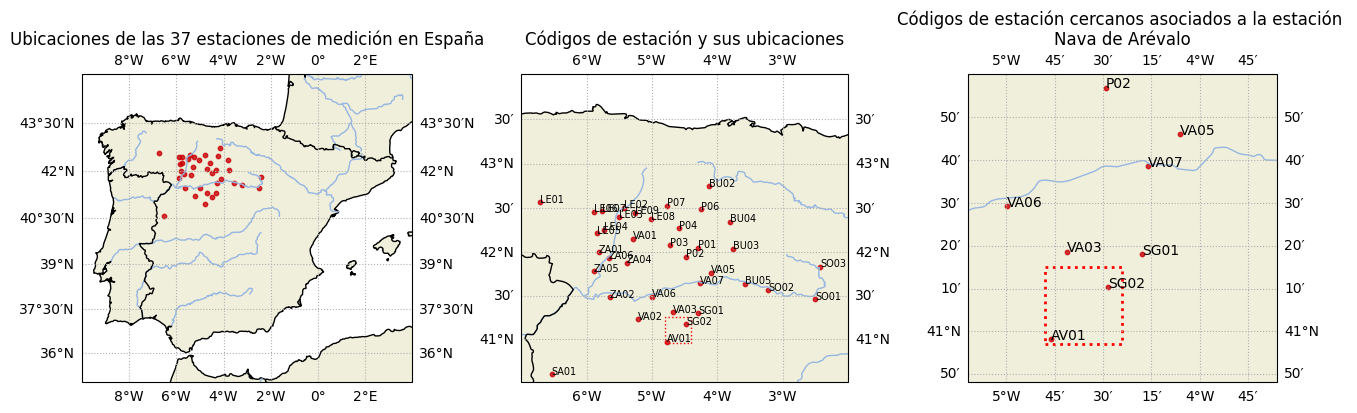

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4), subplot_kw={'projection': ccrs.Mercator()})

ax[0].set_extent([-10, 4, 35, 45])
ax[0].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, linestyle=":");
ax[0].add_feature(cf.COASTLINE)
ax[0].add_feature(cf.LAND)
ax[0].add_feature(cf.RIVERS)
ax[0].add_feature(cf.BORDERS)

ax[0].scatter(df_geo['longitude'], df_geo['latitude'], marker='o', s=10, alpha=0.8, c='#CB0006', transform=ccrs.PlateCarree())
ax[0].set_title('Ubicaciones de las 37 estaciones de medición en España')

ax[1].set_extent([-7, -2, 40.5, 44])
ax[1].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, linestyle=":");
ax[1].add_feature(cf.COASTLINE)
ax[1].add_feature(cf.LAND)
ax[1].add_feature(cf.RIVERS)
ax[1].add_feature(cf.BORDERS)
ax[1].scatter(df_geo['longitude'], df_geo['latitude'], marker='o', s=10, alpha=0.8, c='#CB0006', transform=ccrs.PlateCarree())
ax[1].set_title('Códigos de estación y sus ubicaciones')

for index, row in df_geo.iterrows():
  ax[1].annotate(text=row['station_code'], xy=(row['longitude'], row['latitude']), fontsize=7, transform=ccrs.PlateCarree())

rect = patches.Rectangle((-4.8, 40.95), .4, .3, linewidth=1, edgecolor='r', linestyle=':', facecolor='none', transform=ccrs.PlateCarree())
ax[1].add_patch(rect)

ax[2].set_extent([-5.2, -3.6, 40.8, 42])
ax[2].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, linestyle=":");
ax[2].add_feature(cf.COASTLINE)
ax[2].add_feature(cf.LAND)
ax[2].add_feature(cf.RIVERS)
ax[2].add_feature(cf.BORDERS)
ax[2].scatter(df_geo['longitude'], df_geo['latitude'], marker='o', s=10, alpha=0.8, c='#CB0006', transform=ccrs.PlateCarree())
ax[2].set_title(f"Códigos de estación cercanos asociados a la estación \n{df_geo[df_geo.station_code == 'AV01']['name'].iloc[0]}")

for index, row in df_geo[df_geo.latitude.between(40, 42) & df_geo.longitude.between(-5, -4)].iterrows():
  ax[2].annotate(text=row['station_code'], xy=(row['longitude'], row['latitude']), fontsize=10, transform=ccrs.PlateCarree())

rect = patches.Rectangle((-4.8, 40.95), .4, .3, linewidth=2, edgecolor='r', linestyle=':', facecolor='none', transform=ccrs.PlateCarree())
ax[2].add_patch(rect)

plt.show()

Se identifica como la estación más cercana a AV01 la estación complementaria SG02.

A través del uso de un paquete desarrollado en python de `DataPreparation()` podemos leer y realizar la preparación de los datos asociados a la estación principal seleccionada AV01 Nava de Arévalo.

In [10]:
# Creamos un objeto station de la clase DataPreparation indicando los datos geográficos así como el nombre de la estación de referencia
station = DataPreparation(station_code='AV01', df_geo=df_geo)
# Indicamos el directorio donde se encuentran los datos para leerlos por medio del método load_data_csv
station.load_data_csv(directory='CasyLeon_by_stations')
# Llamamos al método find_null_values para encontrar las filas con valores nulos existentes en la columnas indicadas
station.find_null_values(columns=['GHI','wind_dir','humidity','precipitation','air_temp','wind_sp'])

2024-06-18 23:24:58,928 INFO Getting parameters for station code 'AV01'
2024-06-18 23:24:58,935 INFO Reading file from local directory 'CasyLeon_by_stations\AV01.csv'
2024-06-18 23:24:59,775 INFO File AV01.csv was successfully read from directory!
2024-06-18 23:24:59,775 INFO Updating timestamp's data type to 'datetime64' using format '%Y-%m-%d %H:%M:%S'
2024-06-18 23:25:00,339 INFO Looking for null values in dataset columns ['GHI', 'wind_dir', 'humidity', 'precipitation', 'air_temp', 'wind_sp']...
2024-06-18 23:25:00,352 WARNING There were found 6828 rows with null values!
2024-06-18 23:25:00,374 INFO 
**GENERATED HISTORY REPORT FOR NULL VALUES**
--------------------------------------------------------
Station code:                                  AV01
Station name:                                  Nava de Arévalo
--------------------------------------------------------
**1. REPORT - 2024-06-18 23:25:00.374892**                                                       
-----------------

Llamamos el método `compare_stations()` indicando la estación complementaría así como un rango de fechas a visualizar en la comparación, indicando además las columnas a ser comparadas

2024-06-18 23:27:15,734 INFO Reading file from local directory 'CasyLeon_by_stations\SG02.csv'
2024-06-18 23:27:16,414 INFO File SG02.csv was successfully read from directory!
2024-06-18 23:27:16,414 INFO Updating timestamp's data type to 'datetime64' using format '%Y-%m-%d %H:%M:%S'
2024-06-18 23:27:16,813 INFO Starting stations comparison...
2024-06-18 23:27:16,813 INFO Comparing stations AV01 and SG02...


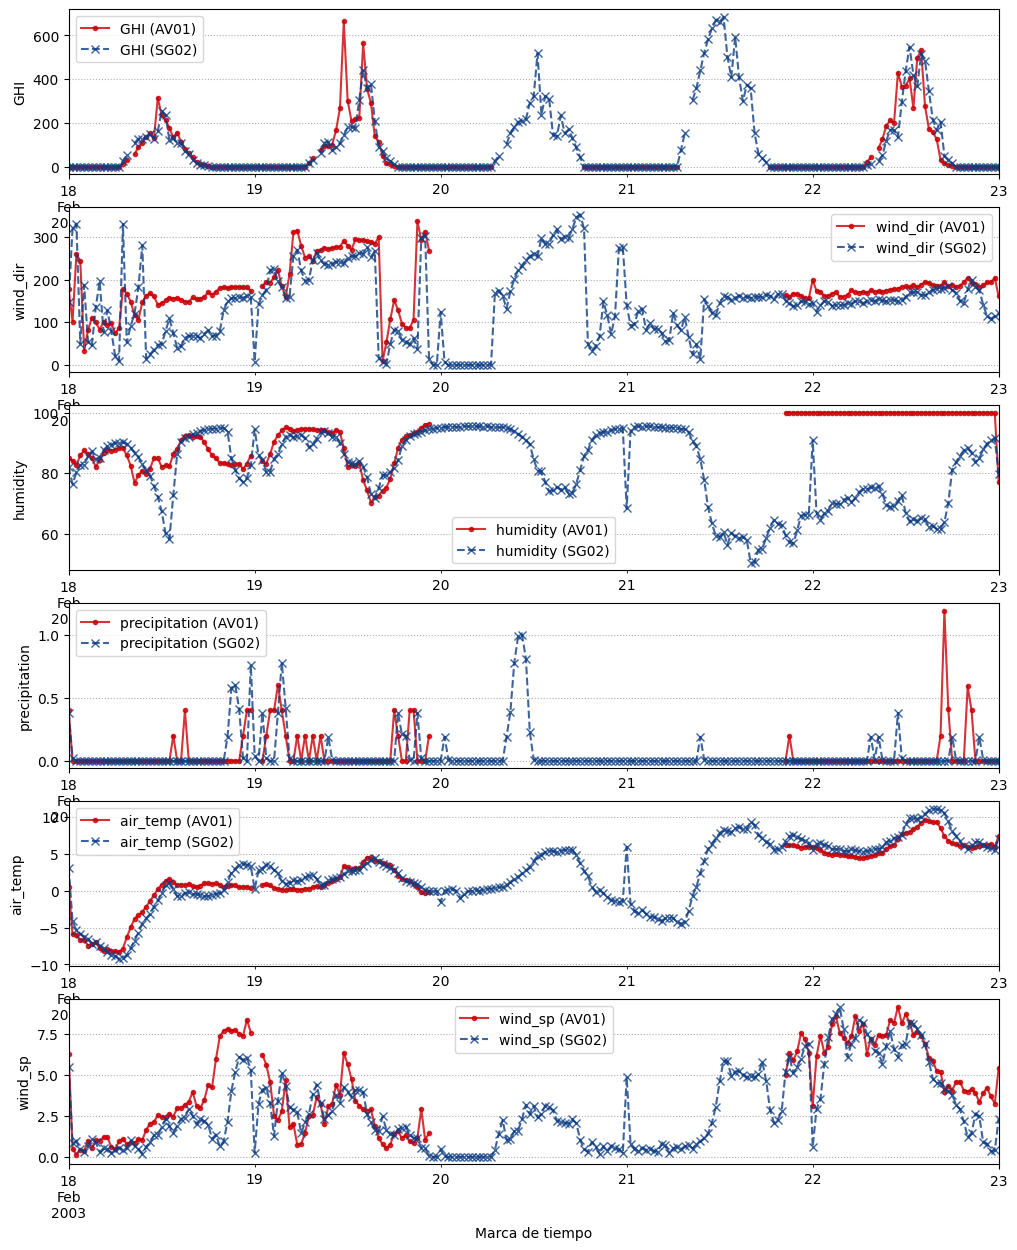

In [11]:
station.compare_stations(comp_station_code='SG02', 
                         start_date='2003-02-18', #2003-02-18
                         end_date='2003-02-23', #2003-02-23
                         meteorological_vars=['GHI','wind_dir','humidity','precipitation','air_temp','wind_sp'])

De forma complementaria obtenemos la similitud de variables entre estaciones haciendo uso de la correlación lineal de Pearson

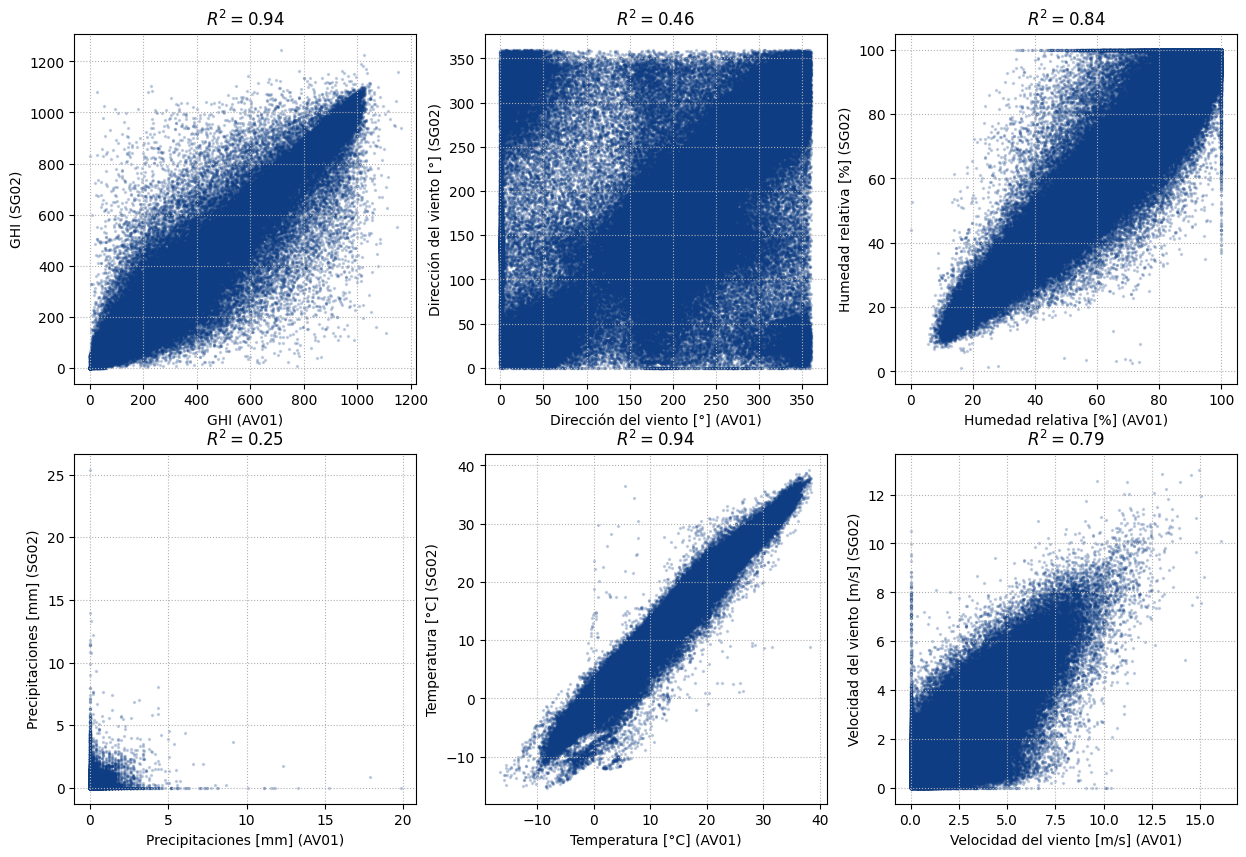

In [14]:
# Verificacion de similitud de variables entre estaciones
df_av01 = pd.read_csv("CasyLeon_by_stations/AV01.csv", sep=',', header=0)
df_sg02 = pd.read_csv("CasyLeon_by_stations/SG02.csv", sep=',', header=0)

fig, ax = plt.subplots(2, 3, figsize=(15, 10))

ax[0,0].scatter(df_av01['GHI'], df_sg02['GHI'], s=8, marker='.', alpha=0.2, c='#0E3D84')
ax[0,0].grid(linestyle=':')
ax[0,0].set_xlabel("GHI (AV01)")
ax[0,0].set_ylabel("GHI (SG02)")
ax[0,0].set_title("$R^{2}=$"+f"{pearsonr(df_av01['GHI'].fillna(0), df_sg02['GHI'].fillna(0)).statistic:.2f}")

ax[0,1].scatter(df_av01['wind_dir'], df_sg02['wind_dir'], s=8, marker='.', alpha=0.2, c='#0E3D84')
ax[0,1].grid(linestyle=':')
ax[0,1].set_xlabel("Dirección del viento [°] (AV01)")
ax[0,1].set_ylabel("Dirección del viento [°] (SG02)")
ax[0,1].set_title("$R^{2}=$"+f"{pearsonr(df_av01['wind_dir'].fillna(0), df_sg02['wind_dir'].fillna(0)).statistic:.2f}")

ax[0,2].scatter(df_av01['humidity'], df_sg02['humidity'], s=8, marker='.', alpha=0.2, c='#0E3D84')
ax[0,2].grid(linestyle=':')
ax[0,2].set_xlabel("Humedad relativa [%] (AV01)")
ax[0,2].set_ylabel("Humedad relativa [%] (SG02)")
ax[0,2].set_title("$R^{2}=$"+f"{pearsonr(df_av01['humidity'].fillna(0), df_sg02['humidity'].fillna(0)).statistic:.2f}")

ax[1,0].scatter(df_av01['precipitation'], df_sg02['precipitation'], s=8, marker='.', alpha=0.2, c='#0E3D84')
ax[1,0].grid(linestyle=':')
ax[1,0].set_xlabel("Precipitaciones [mm] (AV01)")
ax[1,0].set_ylabel("Precipitaciones [mm] (SG02)")
ax[1,0].set_title("$R^{2}=$"+f"{pearsonr(df_av01['precipitation'].fillna(0), df_sg02['precipitation'].fillna(0)).statistic:.2f}")

ax[1,1].scatter(df_av01['air_temp'], df_sg02['air_temp'], s=8, marker='.', alpha=0.2, c='#0E3D84')
ax[1,1].grid(linestyle=':')
ax[1,1].set_xlabel("Temperatura [°C] (AV01)")
ax[1,1].set_ylabel("Temperatura [°C] (SG02)")
ax[1,1].set_title("$R^{2}=$"+f"{pearsonr(df_av01['air_temp'].fillna(0), df_sg02['air_temp'].fillna(0)).statistic:.2f}")

ax[1,2].scatter(df_av01['wind_sp'], df_sg02['wind_sp'], s=8, marker='.', alpha=0.2, c='#0E3D84')
ax[1,2].grid(linestyle=':')
ax[1,2].set_xlabel("Velocidad del viento [m/s] (AV01)")
ax[1,2].set_ylabel("Velocidad del viento [m/s] (SG02)")
ax[1,2].set_title("$R^{2}=$"+f"{pearsonr(df_av01['wind_sp'].fillna(0), df_sg02['wind_sp'].fillna(0)).statistic:.2f}")

plt.show()

Realizamos la imputación de datos llamando el método `data_imputation()` de la clase `DataPreparation()`.

La imputación de datos incluye un complemento de los datos faltantes de AV01 a partir de la estación complementaria SG02, así como una interpolación realizada bajo cierto límite de interpolación, y buscando evitar afectar la consistencia de los datos.

Para este caso se habilita la interpolación por medio del atributo `interpolate` y se indica el límite de interpolación con un valor de 5.

In [15]:
df_station = station.data_imputation(meteorological_vars=['GHI','wind_dir','humidity','precipitation','air_temp','wind_sp'],
                                     interpolate=True,
                                     interpolation_limit=5) # Indicamos un límite 
df_station

2024-06-18 23:40:55,013 INFO Filling 'AV01' null values by using available data from station 'SG02'
2024-06-18 23:40:55,014 INFO Merging dataframes from AV01 and SG02
2024-06-18 23:40:55,068 INFO Filling null values...
2024-06-18 23:40:55,185 INFO Interpolation is enabled
2024-06-18 23:40:55,185 INFO Interpolation was configured for a maximum of 5 consecutive null values
2024-06-18 23:40:55,468 INFO Looking for null values in dataset columns ['GHI', 'wind_dir', 'humidity', 'precipitation', 'air_temp', 'wind_sp']...
2024-06-18 23:40:55,482 WARNING There were found 1963 rows with null values!
2024-06-18 23:40:55,496 INFO 
**GENERATED HISTORY REPORT FOR NULL VALUES**
--------------------------------------------------------
Station code:                                  AV01
Station name:                                  Nava de Arévalo
--------------------------------------------------------
**1. REPORT - 2024-06-18 23:25:00.374892**                                                       


,timestamp,GHI,toa,wind_dir,humidity,precipitation,air_temp,wind_sp,sun_elev,sun_azim
0,2002-01-01 00:00:00,0.0,0.0,142.80,81.81,0.0,8.67,2.27,-71.62,345.99
1,2002-01-01 00:30:00,0.0,0.0,142.80,81.81,0.0,8.67,2.27,-71.92,8.14
2,2002-01-01 01:00:00,0.0,0.0,147.96,82.59,0.0,8.54,2.37,-70.11,28.73
3,2002-01-01 01:30:00,0.0,0.0,153.16,82.90,0.0,8.60,2.29,-66.69,45.10
4,2002-01-01 02:00:00,0.0,0.0,156.67,83.40,0.0,8.49,1.52,-62.26,57.44
...,...,...,...,...,...,...,...,...,...,...
315595,2020-01-01 21:30:00,0.0,0.0,169.96,97.20,0.0,-0.18,1.62,-50.36,283.73
315596,2020-01-01 22:00:00,0.0,0.0,179.52,96.90,0.0,-0.72,0.86,-55.76,290.90
315597,2020-01-01 22:30:00,0.0,0.0,187.43,95.21,0.0,-0.62,0.81,-60.88,299.75
315598,2020-01-01 23:00:00,0.0,0.0,183.14,91.33,0.0,-1.18,0.36,-65.50,311.18


Luego de la interpolación de datos el módulo actualiza el reporte de nulos realizado originalmente agregando una nueva seccón "DATA IMPUTATION REPORT" mostrando una reducción en la cantidad de valores nulos, pasando de 6828 a 1963 y a solo 59 fechas que presentan al menos un valor nulo en todo el dataset.

In [18]:
# Visualizamos la cantidad de nulos restantes ordenando por marca de tiempo para las primeras 10 fechas que los presentan
station.df_dates_null.sort_values(by='timestamp').head(10)

,timestamp,nulls_count
0,2011-01-26,35
1,2011-01-27,3
2,2012-06-05,1
3,2012-12-08,39
4,2013-02-14,39
5,2013-05-13,38
6,2013-05-14,45
7,2013-05-16,42
8,2013-05-17,48
9,2013-05-18,45


Se observa que posterior a la imputación solo siguen existiendo nulos a partir del 26 de enero de 2011

Al comparar nuevamente las estaciones observamos en la línea punteada el nuevo GHI definido para AV01 posterior a la imputación de datos

2024-06-18 23:46:43,233 INFO Reading file from local directory 'CasyLeon_by_stations\SG02.csv'
2024-06-18 23:46:43,887 INFO File SG02.csv was successfully read from directory!
2024-06-18 23:46:43,887 INFO Updating timestamp's data type to 'datetime64' using format '%Y-%m-%d %H:%M:%S'
2024-06-18 23:46:44,280 INFO Starting stations comparison...
2024-06-18 23:46:44,296 INFO Comparing stations AV01 and SG02...


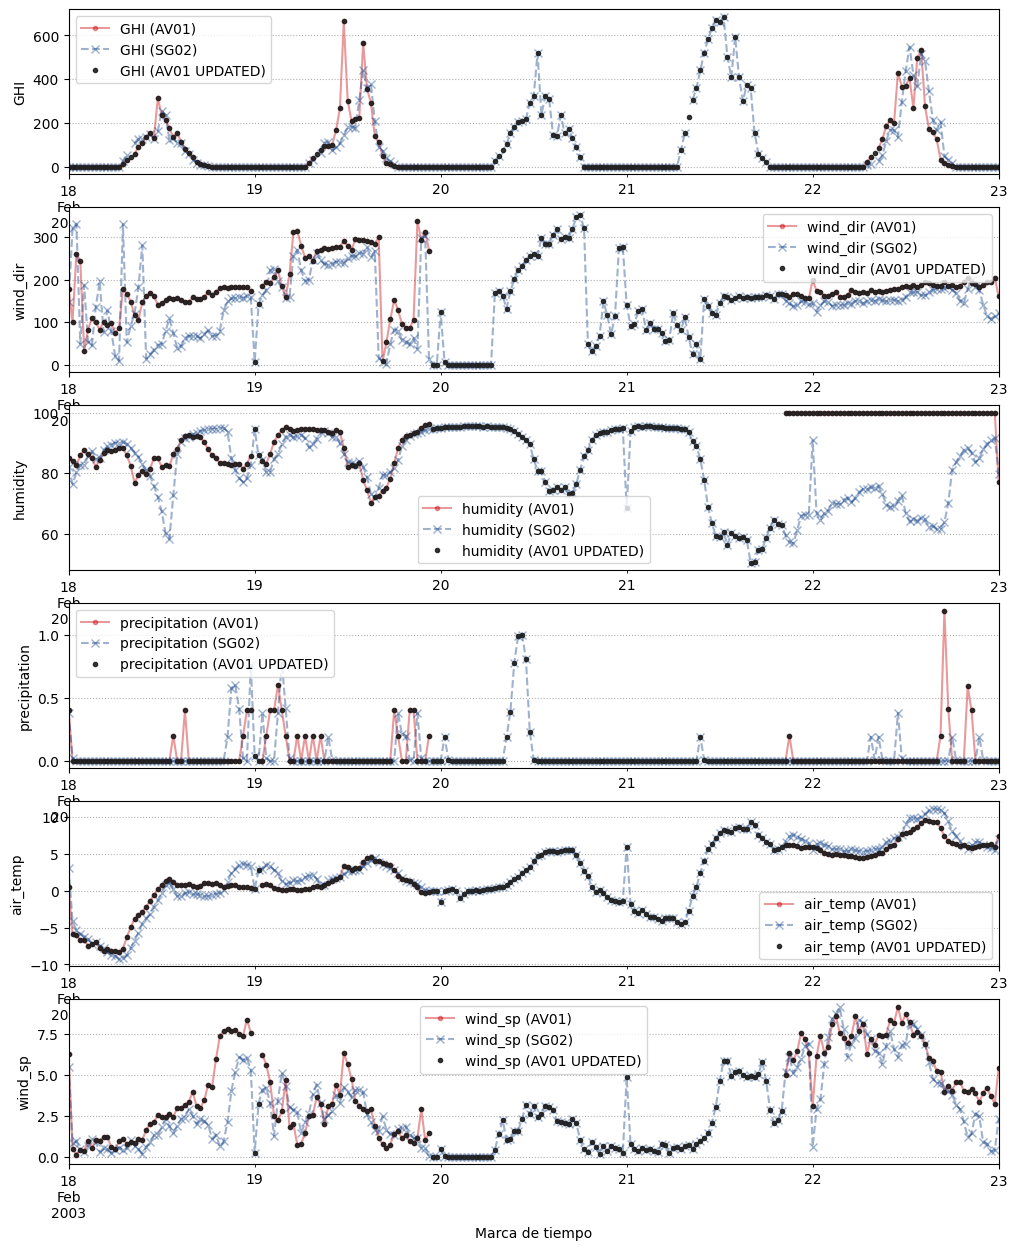

In [19]:
station.compare_stations(comp_station_code='SG02', 
                         start_date='2003-02-18', 
                         end_date='2003-02-23', 
                         meteorological_vars=['GHI','wind_dir','humidity','precipitation','air_temp','wind_sp'])

2024-06-18 23:47:38,262 INFO Reading file from local directory 'CasyLeon_by_stations\SG02.csv'
2024-06-18 23:47:38,922 INFO File SG02.csv was successfully read from directory!
2024-06-18 23:47:38,922 INFO Updating timestamp's data type to 'datetime64' using format '%Y-%m-%d %H:%M:%S'
2024-06-18 23:47:39,288 INFO Starting stations comparison...
2024-06-18 23:47:39,288 INFO Comparing stations AV01 and SG02...


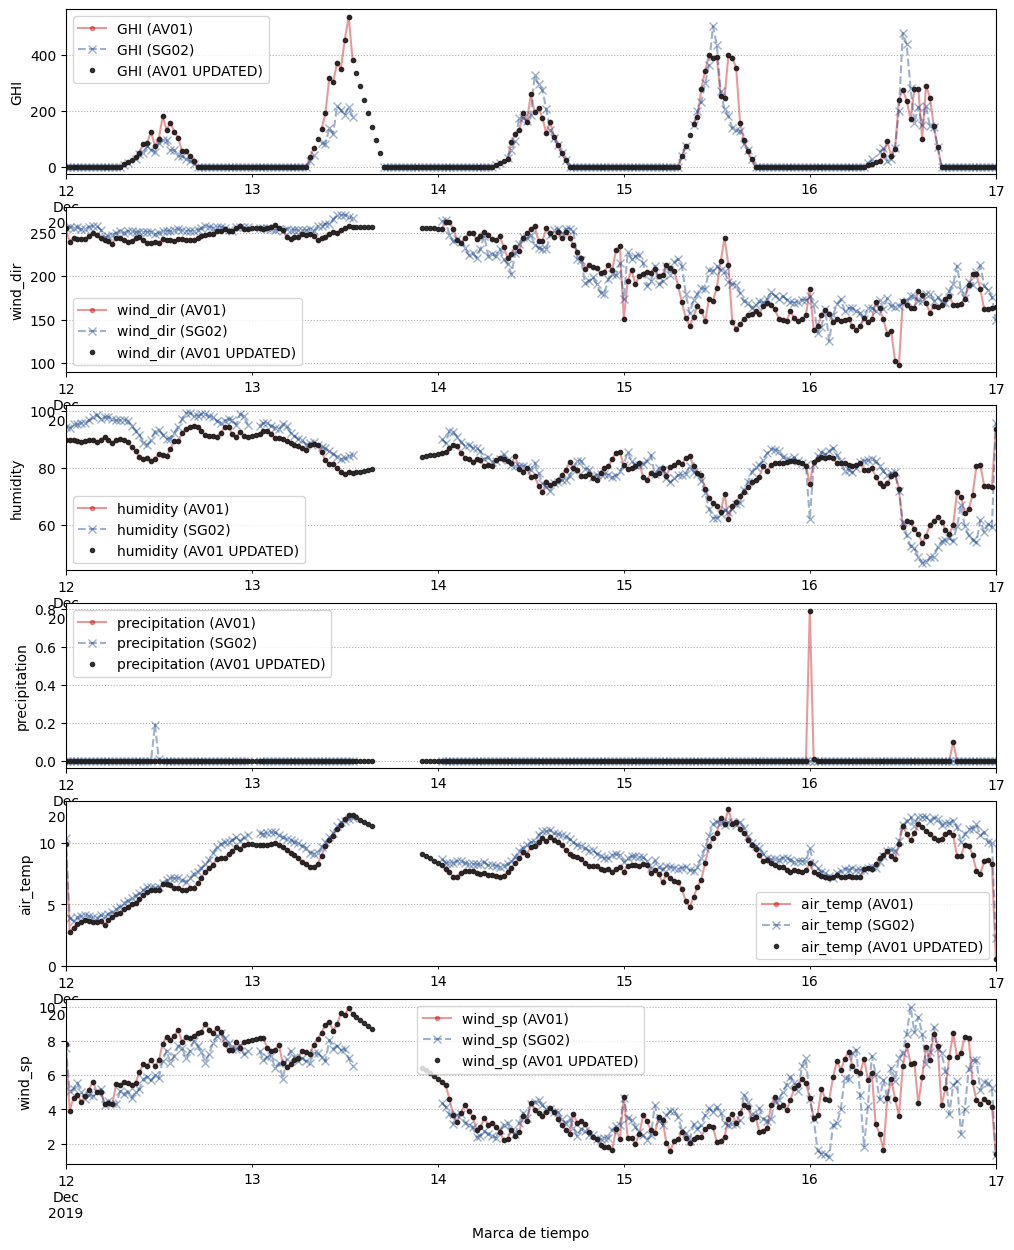

In [20]:
# Observamos algunas fechas diferentes
station.compare_stations(comp_station_code='SG02', 
                         start_date='2019-12-12',
                         end_date='2019-12-17',
                         meteorological_vars=['GHI','wind_dir','humidity','precipitation','air_temp','wind_sp'])

2024-06-18 23:47:57,938 INFO Reading file from local directory 'CasyLeon_by_stations\SG02.csv'
2024-06-18 23:47:58,754 INFO File SG02.csv was successfully read from directory!
2024-06-18 23:47:58,756 INFO Updating timestamp's data type to 'datetime64' using format '%Y-%m-%d %H:%M:%S'
2024-06-18 23:47:59,553 INFO Starting stations comparison...
2024-06-18 23:47:59,553 INFO Comparing stations AV01 and SG02...


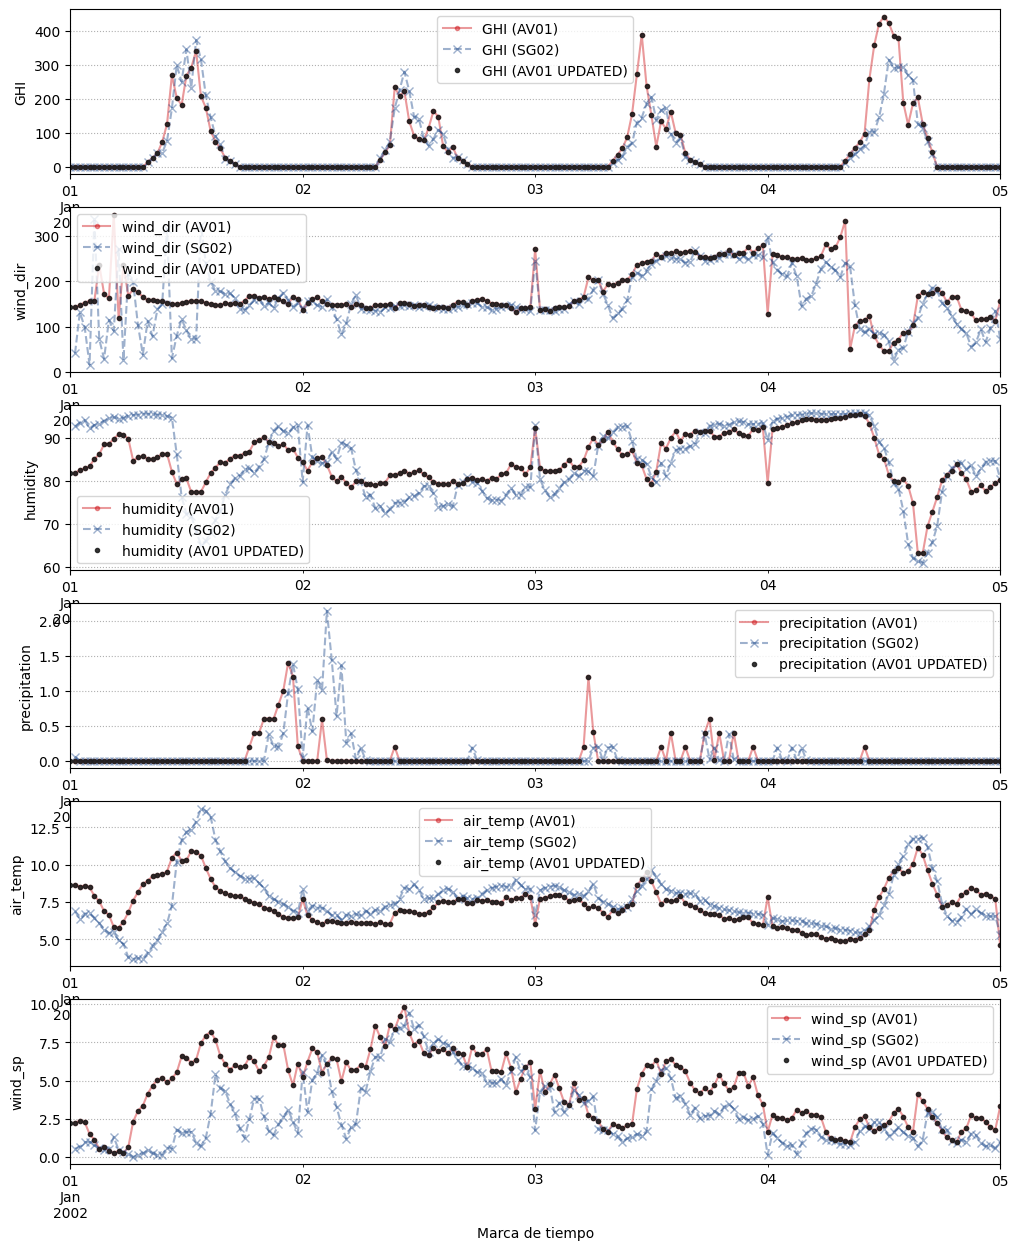

In [21]:
station.compare_stations(comp_station_code='SG02', 
                         start_date='2002-01-01', #2003-02-18
                         end_date='2002-01-05', #2003-02-23
                         meteorological_vars=['GHI','wind_dir','humidity','precipitation','air_temp','wind_sp'])

De acuerdo a lo anterior, se define como dataset preparado a los datos que van desde el 2002-01-01 hasta el 2010-12-31.

In [22]:
df_temp: pd.DataFrame = station.df_station[station.df_station.timestamp.between('2002-01-01 00:00:00', '2010-12-31 23:59:59')].copy()
df_temp

,timestamp,GHI,toa,wind_dir,humidity,precipitation,air_temp,wind_sp,sun_elev,sun_azim
0,2002-01-01 00:00:00,0.0,0.0,142.80,81.81,0.0,8.67,2.27,-71.62,345.99
1,2002-01-01 00:30:00,0.0,0.0,142.80,81.81,0.0,8.67,2.27,-71.92,8.14
2,2002-01-01 01:00:00,0.0,0.0,147.96,82.59,0.0,8.54,2.37,-70.11,28.73
3,2002-01-01 01:30:00,0.0,0.0,153.16,82.90,0.0,8.60,2.29,-66.69,45.10
4,2002-01-01 02:00:00,0.0,0.0,156.67,83.40,0.0,8.49,1.52,-62.26,57.44
...,...,...,...,...,...,...,...,...,...,...
157771,2010-12-31 21:30:00,0.0,0.0,167.18,88.50,0.0,5.78,2.95,-50.47,283.73
157772,2010-12-31 22:00:00,0.0,0.0,172.75,88.10,0.0,5.82,2.51,-55.87,290.91
157773,2010-12-31 22:30:00,0.0,0.0,169.03,89.59,0.0,5.23,1.97,-60.99,299.78
157774,2010-12-31 23:00:00,0.0,0.0,174.85,90.69,0.0,4.78,2.09,-65.61,311.24


Con el objetivo de complementar la información original, se realiza la inclusión de variables relevantes, como el día del año para capturar la variabilidad interanual y los minutos del día para capturar la variabilidad intradía, así como un índice de atenuación definido a partir de la ecuación:

$$attenuation\_index = \frac{TOA-GHI}{TOA}$$

In [23]:
# Cálculo del día del año y el minuto del dia
df_temp['day_of_year'] = df_temp['timestamp'].dt.dayofyear
df_temp['total_minutes_day'] = df_temp['timestamp'].dt.hour * 60 + df_temp['timestamp'].dt.minute

# Creación del índice de atenuación
epsilon = np.finfo(np.float64).eps
df_temp['attenuation_index'] = (df_temp['toa'] - df_temp['GHI'])/ (df_temp['toa'] + epsilon)

In [28]:
# Creamos un directorio donde se almacenarán los datos
os.makedirs('data/', exist_ok=True)

# Guardamos el conjunto de datos
df_temp.to_feather('data/dataset.feather')